<br>
<h1 style = "font-size:60px; font-family:Garamond ; font-weight : normal; background-color: #f6f5f5 ; color : #fe346e; text-align: center; border-radius: 100px 100px;">Differential expression & cluster annotation</h1>
<br>

Now that we've assigned cells into clusters, we'd like to understand **what makes each cluster different from other cells in the dataset, or to annotate clusters according to their cell types (as has been previously done for this dataset).**

There are several approaches to this task:

- **Look for upregulation of marker genes for cell types of interest (compared to the rest of the dataset)**
- **Compare the complete gene expression profiles between groups**
- **Use automated methods to compare cells of interest to databases of cell type expression profiles to combine clustering and annotation**
- Automated methods are a promising advance, but are not yet able to replace careful human curation.

**For well-defined cell types, we expect marker genes to show large differences in expression between the cell type of interest and the rest of the dataset, allowing us to use simple methods.** We'll focus on this approach.

### Installations

In [1]:
!pip install -q scanpy

import scanpy as sc
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from matplotlib import pyplot as plt
# magic incantation to help matplotlib work with our jupyter notebook
%matplotlib inline 

### Load Data

<b>Important note! For differential expression, we need to use the raw values stored in adata.raw. </b>

With differential expression, we want to account for both the center and spread of the expression in each group. Recall that when we normalized our values, we standardized the distribution of each gene across cells to be centered at 0 and scaled with variance 1. So, when calculating differential expression, **we should use the raw values (post-QC, pre-normalization). We saved these in adata.raw earlier on.**

In [2]:
adata = sc.read('../input/theory-introto-singlecell-rnaseq-images/brain_clusters/brain_clusters.h5ad')
raw = pd.DataFrame(data=adata.raw.X, index=adata.raw.obs_names, columns=adata.raw.var_names)

In [4]:
adata

AnnData object with n_obs × n_vars = 3210 × 18585
    obs: 'cell_ontology_class', 'subtissue', 'mouse.sex', 'mouse.id', 'plate.barcode', 'n_genes', 'n_counts', 'kmeans', 'louvain'
    var: 'ERCC', 'n_cells', 'n_counts', 'mean', 'std'
    uns: 'cell_ontology_class_colors', 'kmeans_colors', 'louvain', 'louvain_colors', 'mouse.id_colors', 'neighbors', 'pca', 'plate.barcode_colors', 'tsne', 'umap'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [6]:
print(raw.shape)
raw.head()

(3210, 18585)


,0610005C13Rik,0610007C21Rik,0610007L01Rik,0610007N19Rik,0610007P08Rik,0610007P14Rik,0610007P22Rik,0610009B14Rik,0610009B22Rik,0610009D07Rik,...,Zwint,Zxda,Zxdb,Zxdc,Zyg11b,Zyx,Zzef1,Zzz3,a,l7Rn6
cell,,,,,,,,,,,,,,,,,,,,,
A1.B003290.3_38_F.1.1,0.0,125.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,54.0
A1.B003728.3_56_F.1.1,0.0,0.0,0.0,0.0,0.0,324.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1.MAA000560.3_10_M.1.1,0.0,348.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,316.0,...,266.0,0.0,0.0,0.0,0.0,0.0,195.0,0.0,0.0,113.0
A1.MAA000564.3_10_M.1.1,0.0,41.0,36.0,0.0,0.0,24.0,0.0,0.0,14.0,0.0,...,0.0,0.0,0.0,0.0,0.0,125.0,0.0,1.0,0.0,0.0
A1.MAA000923.3_9_M.1.1,0.0,53.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0


<h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">Comparing distributions </h1>

- Differential expression algorithms represent various approaches to comparing the distribution of gene expression in one group versus another group. 
- Unlike bulk RNA-seq, we generally have a large number of samples (i.e. cells) for each group we are comparing in single-cell experiments. 
- Thus, **we can take advantage of the whole distribution of expression values in each group to identify differences between groups rather than only comparing estimates of mean-expression as is standard for bulk RNASeq..**

# Building intuition 
Let's revisit some foundational statistics to build some intuition.

In this example, we have a cluster of interest, and we want to determine if they are astrocytes. Let's start by plotting the distibution of a marker gene's expression in the cluster compared to the rest of the dataset.

In [15]:
adata.obs.cell_ontology_class.unique()

['astrocyte', 'oligodendrocyte', 'endothelial cell', 'neuron', 'oligodendrocyte precursor cell', 'Bergmann glial cell', 'brain pericyte']
Categories (7, object): ['Bergmann glial cell', 'astrocyte', 'brain pericyte', 'endothelial cell', 'neuron', 'oligodendrocyte', 'oligodendrocyte precursor cell']

In [7]:
astrocyte_marker = 'Gja1' # define genes of interest
# housekeeping = 'Chmp2a' 

cluster2 = raw[adata.obs['louvain'] == '2'] # Use a mask to subset dataset to cells assigned to cluster 2
not_cluster2 = raw[adata.obs['louvain'] != '2'] # All other cells

In [9]:
cluster2.head()  # Dataframe containing cells belonging to cluster 2

,0610005C13Rik,0610007C21Rik,0610007L01Rik,0610007N19Rik,0610007P08Rik,0610007P14Rik,0610007P22Rik,0610009B14Rik,0610009B22Rik,0610009D07Rik,...,Zwint,Zxda,Zxdb,Zxdc,Zyg11b,Zyx,Zzef1,Zzz3,a,l7Rn6
cell,,,,,,,,,,,,,,,,,,,,,
A1.B003290.3_38_F.1.1,0.0,125.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,54.0
A1.B003728.3_56_F.1.1,0.0,0.0,0.0,0.0,0.0,324.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1.MAA000923.3_9_M.1.1,0.0,53.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0
A1.MAA000930.3_8_M.1.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,587.0,...,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0
A10.MAA000926.3_9_M.1.1,0.0,136.0,0.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,76.0,181.0,0.0,129.0


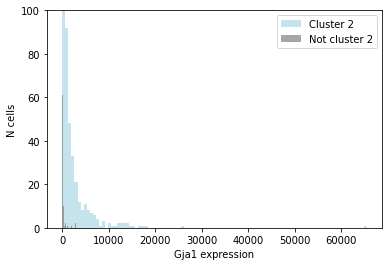

In [18]:
cluster2_marker_exp = cluster2[astrocyte_marker]  # getting the values for all cells of cluster 2 for the specific gene
plt.hist(cluster2_marker_exp.values, bins=100, color='lightblue', alpha=0.7, label='Cluster 2') # Plot distribution

not_cluster2_marker_exp = not_cluster2[astrocyte_marker]  # # getting the values for all cells not belonging to cluster 2 for the specific gene
plt.hist(not_cluster2_marker_exp, bins=100, color='gray', alpha=0.7, label='Not cluster 2')

plt.ylim(0,100) # Cut off at N=100 for visual clarity
plt.xlabel('%s expression'%astrocyte_marker) # label our axes
plt.ylabel('N cells')
plt.legend()

**Just by eyeballing the two distributions we can see that:**
- Cells in this **cluster express more of the marker gene than other cells** in the dataset. 
- However, we also see that these distributions overlap: **some cells in the cluster don't express the gene at all, and some cells outside the cluster express it relatively highly.**

**So, how do we decide whether this cluster is actually "differentially expressing" our marker gene?**
- Because we expect the differences in expression to be relatively large for marker genes, we can use straightforward hypothesis testing methods to ask for the probability (p-value) that we would observe this level of differential expression if all these cells were, in fact, the same population (i.e., if the null hypothesis were true).

### T-test
Suppose we observe two independent samples, e.g. flower petal lengths, and we are considering whether the two samples were drawn from the same population (e.g. the same species of flower or two species with similar petal characteristics) or two different populations.

- The t-test quantifies the difference between the arithmetic means of the two samples. The p-value quantifies the probability of observing as or more extreme values assuming the null hypothesis, that the samples are drawn from populations with the same population means, is true. 
- A p-value larger than a chosen threshold (e.g. 5% or 1%) indicates that our observation is not so unlikely to have occurred by chance. Therefore, we do not reject the null hypothesis of equal population means. If the p-value is smaller than our threshold, then we have evidence against the null hypothesis of equal population means.
- A t-test compares our data to the null hypothesis that the means of two distributions are **equal**. This accounts for the mean, standard deviation, and sample size of the two distributions. However, a p-value alone does not tell us anything about the *magnitude* of that difference: with large N, even very small (and biologically meaningless) differences in expression values can still return very "statistically significant" p-values.

In [20]:
from scipy.stats import ttest_ind

ttest = ttest_ind(cluster2_marker_exp, 
          not_cluster2_marker_exp, 
          equal_var=False, # it's not necessarily fair to assume that these two populations have equal variance
          nan_policy='omit') # omit NaN values
print(ttest)

Ttest_indResult(statistic=10.472000376695075, pvalue=2.3204030965250666e-23)


- This result tells you that we would be very surprised if these two populations had no true difference in mean expression, given the observed sample.
- Notably, although many cells in this cluster express the marker gene, there are many that don't. We should be careful before assuming that a cluster == a cell type!

<h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">Working with the whole dataset </h1>

- **Scanpy has a very useful function for repeating this process of subsetting the dataset to one group and comparing it to the rest of the dataset.** 
- It then **returns the genes that are most differentially expressed between that group and all others**. Let's look at the genes that are most cell-type specific.

#### Computing differential expression vai using "cell_ontology_class

/opt/conda/lib/python3.7/site-packages/scanpy/tools/_rank_genes_groups.py:417: RuntimeWarning: overflow encountered in expm1
  foldchanges = (self.expm1_func(mean_group) + 1e-9) / (
/opt/conda/lib/python3.7/site-packages/scanpy/tools/_rank_genes_groups.py:418: RuntimeWarning: overflow encountered in expm1
  self.expm1_func(mean_rest) + 1e-9
/opt/conda/lib/python3.7/site-packages/scanpy/tools/_rank_genes_groups.py:418: RuntimeWarning: invalid value encountered in true_divide
  self.expm1_func(mean_rest) + 1e-9


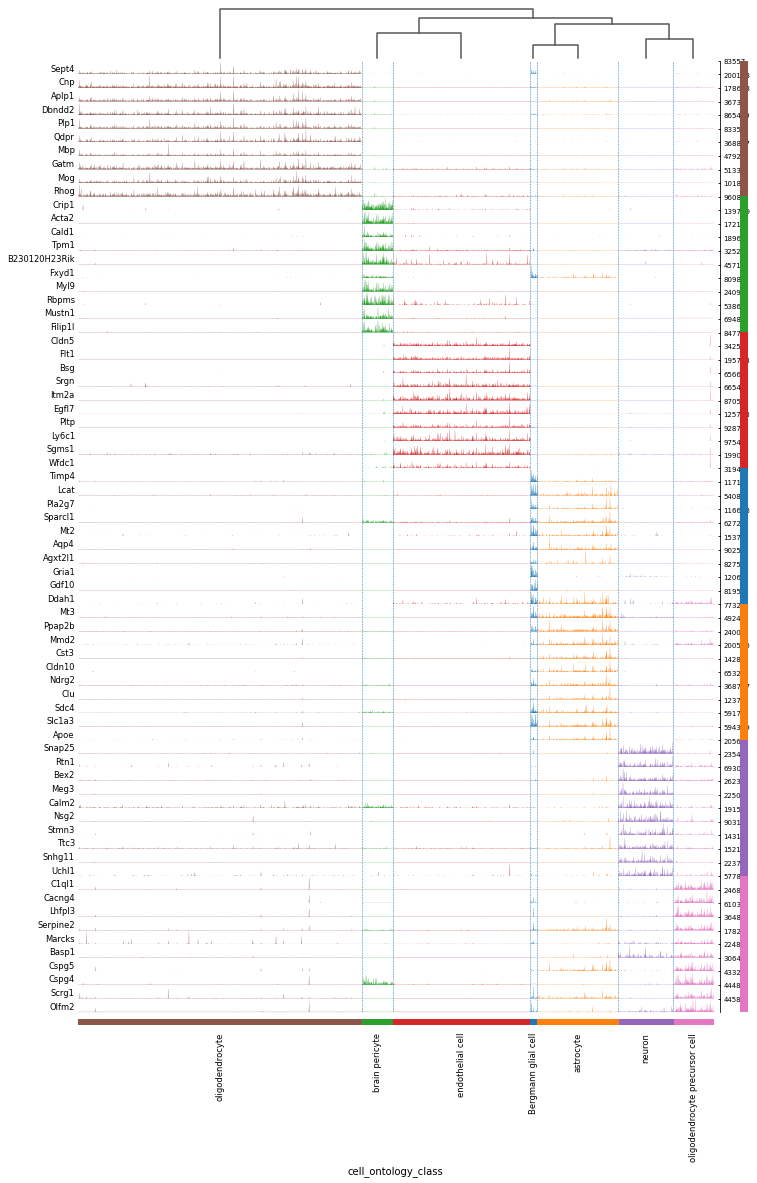

In [24]:
# Rank genes for characterizing groups
sc.tl.rank_genes_groups(adata, groupby='cell_ontology_class', use_raw=True, 
                        method='t-test_overestim_var', n_genes=10) # compute differential expression
# The key of the observations grouping to consider.-> "cell_ontology_class"
sc.pl.rank_genes_groups_tracksplot(adata, groupby='cell_ontology_class')  # Plot ranking of genes using heatmap plot (

In [25]:
adata

AnnData object with n_obs × n_vars = 3210 × 18585
    obs: 'cell_ontology_class', 'subtissue', 'mouse.sex', 'mouse.id', 'plate.barcode', 'n_genes', 'n_counts', 'kmeans', 'louvain'
    var: 'ERCC', 'n_cells', 'n_counts', 'mean', 'std'
    uns: 'cell_ontology_class_colors', 'kmeans_colors', 'louvain', 'louvain_colors', 'mouse.id_colors', 'neighbors', 'pca', 'plate.barcode_colors', 'tsne', 'umap', 'rank_genes_groups', 'dendrogram_cell_ontology_class'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

#### Computing differential expression vai using "louvain" clusters

/opt/conda/lib/python3.7/site-packages/scanpy/tools/_rank_genes_groups.py:417: RuntimeWarning: overflow encountered in expm1
  foldchanges = (self.expm1_func(mean_group) + 1e-9) / (
/opt/conda/lib/python3.7/site-packages/scanpy/tools/_rank_genes_groups.py:418: RuntimeWarning: overflow encountered in expm1
  self.expm1_func(mean_rest) + 1e-9
/opt/conda/lib/python3.7/site-packages/scanpy/tools/_rank_genes_groups.py:418: RuntimeWarning: invalid value encountered in true_divide
  self.expm1_func(mean_rest) + 1e-9


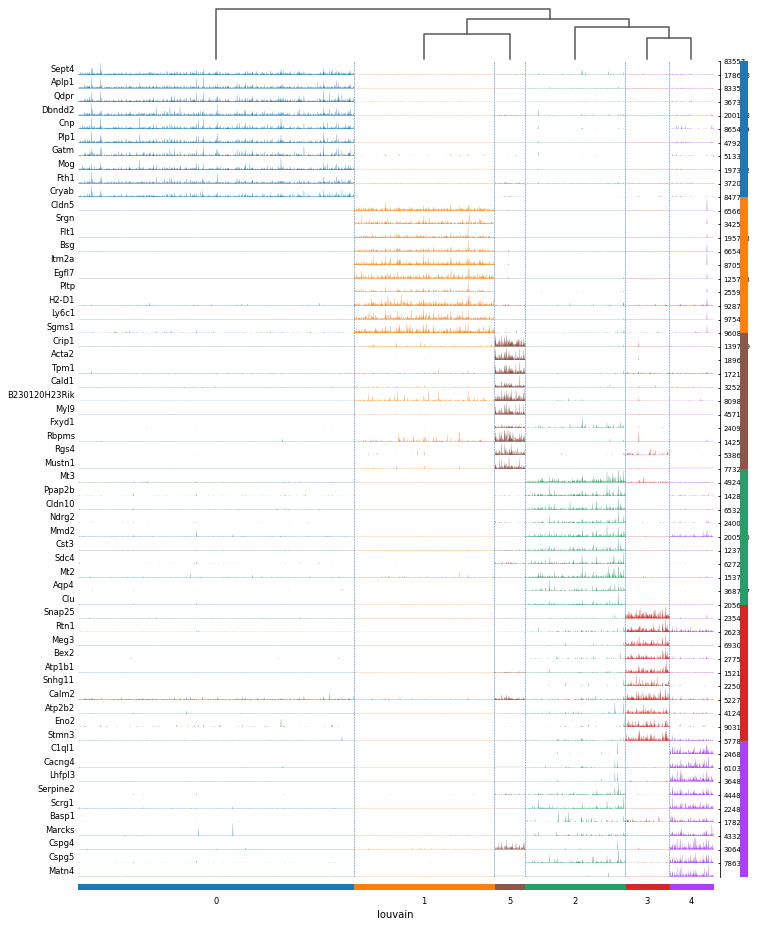

In [28]:
sc.tl.rank_genes_groups(adata, groupby='louvain', use_raw=True, 
                        method='t-test_overestim_var', n_genes=10) # compute differential expression
sc.pl.rank_genes_groups_tracksplot(adata, groupby='louvain') # Plot ranking of genes using heatmap plot (

<h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">Comparing to "known" marker genes </h1>


We can also compare these data-driven marker genes to those considered by the field to be classic indicators of cell type.

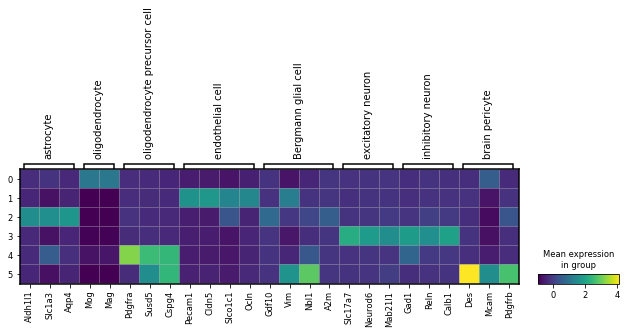

In [29]:
marker_genes = {
'astrocyte': ['Aldh1l1', 'Slc1a3', 'Aqp4'], 
'oligodendrocyte': ['Mog','Mag'],
'oligodendrocyte precursor cell': ['Pdgfra','Susd5','Cspg4'],
'endothelial cell': ['Pecam1','Cldn5','Slco1c1','Ocln'],
'Bergmann glial cell': ['Gdf10','Vim','Nbl1','A2m'],
'excitatory neuron': ['Slc17a7','Neurod6','Mab21l1'],
'inhibitory neuron': ['Gad1','Reln','Calb1'],
'brain pericyte': ['Des','Mcam','Pdgfrb']
}

sc.pl.matrixplot(adata, marker_genes, groupby='louvain', use_raw=False)

<br>
<h1 style = "font-size:60px; font-family:Garamond ; font-weight : normal; background-color: #f6f5f5 ; color : #fe346e; text-align: center; border-radius: 100px 100px;">Summary</h1>
<br>

- Building intuition of differential expression
- Ttest
- Working with whole dataset using original labels - "cell_ontology_class"
- Working with whole dataset using "louvain" clusters
- Comapring to known marker genes of call classes

https://chanzuckerberg.github.io/scRNA-python-workshop/analysis/05-diffexp.html